In [56]:
import os
import torch
import math
import torch
import torchvision
import pandas as pd
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from PIL import Image
from torch import optim
from tqdm import tqdm
import logging
from torch.utils.tensorboard import SummaryWriter

In [57]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")
def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

# Diffusion class copied from ... changed the noise schedule to a cosine noising instead of a linear, with influence from OpenAI's diffusion code:
 https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/gaussian_diffusion.py

In [58]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=0.0001, beta_end=0.02, sequence_length=144, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.sequence_length = sequence_length
        self.device = device

        self.beta = self.schedule_noise().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def schedule_noise(self):
        s = 0.008
        e = 1.008
        max_beta = 0.999
        
        timesteps = torch.linspace(0, 1, self.noise_steps)
        alpha_bar = torch.cos((timesteps * (e - s) + s) * math.pi / 2) ** 2
        beta = 1. - alpha_bar[:-1] / alpha_bar[1:] 
        beta = torch.clip(beta, max=max_beta) 
        
        beta_scaled = beta * (self.beta_end - self.beta_start) + self.beta_start
        
        return beta_scaled
    
    def noise_image(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t]).unsqueeze(1).unsqueeze(-1)  # shape [batch_size, 1, 1]
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t]).unsqueeze(1).unsqueeze(-1)  # shape [batch_size, 1, 1]

        epsilon = torch.randn_like(x)
    
        print("Before adding noise, x dimensions: ", x.shape)
    
        # These operations should now maintain the original channel dimension of x
        noisy_image = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon
    
        print("After adding noise, dimensions: ", noisy_image.shape)
    
        return noisy_image.float(), epsilon.float()

    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new sequences...")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.sequence_length)).to(self.device)
            for i in tqdm(reversed(range(1,self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                beta = self.beta[t][:, None]
                alpha = self.alpha[t][:, None]
                alpha_hat = self.alpha_hat[t][:, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        # Ensure values are whole numbers between 0 and 7 to be converted back to tabular format
        x = torch.round(x) 
        x = torch.clamp(x, 0, 7)
        return x

# Convert table data to images using Fred's discrete encoder class

In [59]:
# Fred's encoder code
class DescreteEncoder:
    def __init__(self, duration: int = 1440, step_size: int = 10):
        self.duration = duration
        self.step_size = step_size
        self.steps = duration // step_size
        self.index_to_acts = {}
        self.acts_to_index = {}

    def encode(self, data: pd.DataFrame):
        # Create mappings from activity to index and vice versa
        self.index_to_acts = {i: a for i, a in enumerate(data.act.unique())}
        self.acts_to_index = {a: i for i, a in self.index_to_acts.items()}
        
        # Create a new DataFrame for encoded data
        encoded_data = data.copy()
        encoded_data['act'] = encoded_data['act'].map(self.acts_to_index)
        return encoded_data
    
    def decode(self, encoded_image_grid) -> pd.DataFrame:
        if isinstance(encoded_image_grid, torch.Tensor):
            encoded_image_grid = encoded_image_grid.numpy()
        
        decoded = []
        for pid in range(encoded_image_grid.shape[0]):
            sequence = encoded_image_grid[pid]
            current_act = None
            act_start = None
            
            for time_step, act_index in enumerate(sequence):
                # If the activity changes or it's the end of the day, record the activity
                if act_index != current_act and current_act is not None:
                    act_end = time_step * self.step_size
                    decoded.append({
                        "pid": pid,
                        "act": self.index_to_acts[current_act],
                        "start": act_start,
                        "end": act_end
                    })
                    act_start = time_step * self.step_size
                # If the activity changes, update the current activity
                if act_index != current_act:
                    current_act = act_index
                    act_start = time_step * self.step_size
            
            # Add the last activity of the day if the day ended with an activity
            if current_act is not None and act_start is not None:
                decoded.append({
                    "pid": pid,
                    "act": self.index_to_acts[current_act],
                    "start": act_start,
                    "end": self.duration
                })

        return pd.DataFrame(decoded, columns=["pid", "act", "start", "end"])
    


In [60]:
data = pd.read_csv('./data/nts_population.csv')
encoder = DescreteEncoder()
encoded_data = encoder.encode(data)

In [61]:
# Function to convert encoded data into an image grid
def create_image_grid(encoded_data, encoder):
    # Map pid to sequential indices starting from 0
    pid_to_index = {pid: index for index, pid in enumerate(encoded_data['pid'].unique())}
    
    num_people = len(pid_to_index)
    time_steps = encoder.steps
    grid = np.zeros((num_people, time_steps))
    
    for _, row in encoded_data.iterrows():
        pid_index = pid_to_index[row['pid']]
        act_index = row['act']
        start_step = row['start'] // encoder.step_size
        end_step = row['end'] // encoder.step_size
        grid[pid_index, start_step:end_step] = act_index
    
    return grid

In [62]:
image_grid = create_image_grid(encoded_data, encoder)

In [63]:
tensor_image_grid = torch.tensor(image_grid)
torch.save(tensor_image_grid, './data/image_grid.pt')

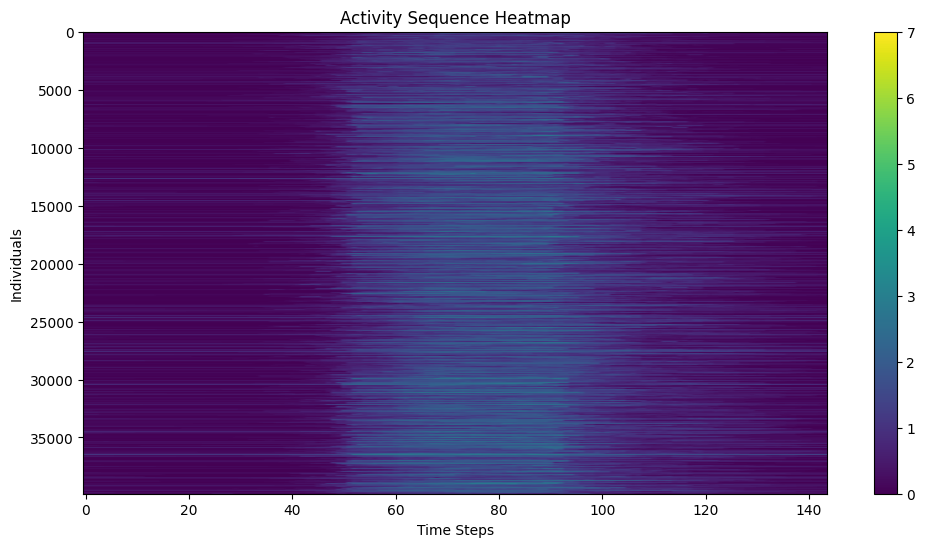

In [64]:
plt.figure(figsize=(12, 6))
plt.imshow(image_grid, aspect='auto')
plt.colorbar()
plt.title('Activity Sequence Heatmap')
plt.xlabel('Time Steps')
plt.ylabel('Individuals')
plt.show()

In [65]:
print(image_grid.shape)

(39850, 144)


## Now need to make some decisions about how to split up the data, batches of 64? 

In [69]:
from torch.utils.data import TensorDataset, DataLoader

# Loading the tensor image grid and processing it
tensor_image_grid = torch.load('./data/image_grid.pt')
tensor_image_grid = tensor_image_grid[:-(tensor_image_grid.shape[0] % 64)] # Remove the last rows to make the number of rows divisible by 64
tensor_image_grid = tensor_image_grid.unsqueeze(1) # Add a channel dimension

print(tensor_image_grid.shape) # torch.Size([64, 1, 144]) is the shape we want

# Create a dataset and dataloader
dataset = TensorDataset(tensor_image_grid)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) # Shuffling sequential data is bad!


for batch in dataloader:
    x = batch[0]  
    #print(x.shape)


torch.Size([39808, 1, 144])


In [67]:
from UNet import UNet
def setup_logging(run_name):
    logging.basicConfig(level=logging.INFO)

def train():
    run_name = "first_run"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    learning_rate = 0.001
    sequence_length = 144
    epochs = 50

    setup_logging(run_name)
    model = UNet(c_in=1, c_out=1, time_dim=256, device=device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse = nn.MSELoss()
    diffusion = Diffusion(sequence_length=sequence_length, device=device)
    logger = SummaryWriter(os.path.join("runs", run_name))

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}")
        epoch_loss = 0.0
        for batch_idx, (x,) in enumerate(tqdm(dataloader)):
            x = x.to(device)
            optimizer.zero_grad()
            
            timesteps = torch.randint(0, sequence_length, (x.size(0),), device=device)
            noisy_x, _ = diffusion.noise_image(x, timesteps)
            predicted_x = model(noisy_x, timesteps)
            
            loss = mse(predicted_x, x)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

            # Log to TensorBoard every N batches
            if batch_idx % 10 == 0:
                logger.add_scalar("Loss/train", loss.item(), epoch * len(dataloader) + batch_idx)

        # Log epoch-level metrics
        avg_epoch_loss = epoch_loss / len(dataloader)
        logging.info(f"Epoch {epoch} Average Loss: {avg_epoch_loss}")
        logger.add_scalar("Loss/epoch_avg_train", avg_epoch_loss, epoch)

    logger.close()

train()

03:00:44 - INFO: Starting epoch 0
  0%|          | 0/622 [00:00<?, ?it/s]

Before adding noise, x dimensions:  torch.Size([64, 1, 144])
After adding noise, dimensions:  torch.Size([64, 1, 144])


  0%|          | 0/622 [00:00<?, ?it/s]


RuntimeError: Given normalized_shape=[32], expected input with shape [*, 32], but got input of size[64, 128, 72]

# Once finished the modified decoder will be used to return the CSV using Fred's modified encoder/decoder class

In [ ]:
tensor_image_grid = torch.load('./data/model_output.pt')  

decoder = DescreteEncoder()
decoded_data = decoder.decode(tensor_image_grid)
decoded_data.to_csv('./data/model_output.csv', index=False)